# Correlación en Python — Automatiza con Max

Bienvenido/a 👋. En este notebook verás:

- Qué es la correlación y cómo interpretarla correctamente.
- Tipos de correlación: **Pearson**, **Spearman**, **Kendall**, **punto-biserial** y **Cramer's V**.
- Cómo **no** interpretar la correlación (errores comunes y *trampas*).
- Cómo detectar y mitigar **multicolinealidad** con **VIF**.
- **Correlación parcial** (\(r_{XY\cdot Z}\)) y **autocorrelación**.

**Reglas visuales del notebook**: Solo `matplotlib`, una gráfica por celda, sin estilos ni colores personalizados.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

np.random.seed(42)

## 1) Dataset sintético para ejemplos
Incluye relaciones lineales, no lineales, variables categóricas y outliers.

In [22]:
n = 500

# Lineal fuerte (X1 y X2)
X1 = np.random.normal(0, 1, n)
X2 = 0.8*X1 + np.random.normal(0, 0.5, n)

# Relación no lineal (X3 ~ sinusoide de X1)
X3 = np.sin(2*np.pi*(X1)) + np.random.normal(0, 0.2, n)

# Heterocedasticidad (X4)
eps = np.random.normal(0, 1 + np.abs(X1), n)
X4 = 0.5*X1 + eps

# Variable con outliers (X5)
X5 = np.random.normal(0, 1, n)
X5[:5] += 10  # 5 outliers grandes

# Variable casi constante (rango restringido) (X6)
X6 = np.random.normal(0, 0.1, n)

# Variable binaria (B) para punto-biserial
B = (np.random.rand(n) > 0.6).astype(int)
# Variable continua relacionada con B
Y_bin = 2*B + np.random.normal(0, 1, n)

# Variables categóricas para Cramer's V
cats1 = np.random.choice(list('ABC'), size=n, p=[0.4, 0.4, 0.2])
cats2 = np.random.choice(list('XYZ'), size=n, p=[0.5, 0.3, 0.2])

df = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'X3': X3,
    'X4': X4,
    'X5': X5,
    'X6': X6,
    'B': B,
    'Y_bin': Y_bin,
    'cat1': cats1,
    'cat2': cats2
})
df.head(500)

,X1,X2,X3,X4,X5,X6,B,Y_bin,cat1,cat2
0,-0.212459,-1.018515,-0.956694,0.704997,8.577367,0.073235,0,0.797252,C,X
1,0.250430,0.721178,1.054181,-0.401133,12.453939,0.079757,1,0.460945,B,Y
2,0.680287,-0.353909,-0.884073,0.221728,11.455498,-0.029520,1,3.228328,A,X
3,-1.157934,-1.096649,-0.959019,-1.682615,12.163976,0.061455,1,1.362974,C,Z
4,-0.064398,-0.163671,-0.402996,-0.256071,10.062447,0.110910,1,0.782329,A,X
...,...,...,...,...,...,...,...,...,...,...
495,0.523219,1.319098,-0.423031,1.054716,0.042039,-0.052902,0,1.445635,A,X
496,1.082379,1.032076,0.231116,3.456727,0.907235,-0.018574,1,1.676409,B,Y
497,1.615982,1.622486,-0.545743,-0.833963,-0.385933,-0.111276,0,0.501894,A,Y
498,0.305173,0.394639,0.968403,-1.789848,-0.236818,0.094834,0,2.099250,C,X


## 2) Correlación de Pearson (lineal, sensible a outliers)
Valores entre -1 y 1. Asume relación lineal y variables numéricas continuas.

In [4]:
numeric_cols = ['X1','X2','X3','X4','X5','X6','Y_bin']
corr_pearson = df[numeric_cols].corr(method='pearson')
corr_pearson

,X1,X2,X3,X4,X5,X6,Y_bin
X1,1.000000,0.837728,-0.041777,0.302658,0.028805,0.031773,0.033332
X2,0.837728,1.000000,-0.033402,0.250731,0.045633,0.055735,0.031119
X3,-0.041777,-0.033402,1.000000,0.056620,-0.062021,0.065798,-0.040024
X4,0.302658,0.250731,0.056620,1.000000,-0.060805,0.047175,-0.027940
X5,0.028805,0.045633,-0.062021,-0.060805,1.000000,-0.025339,0.065078
X6,0.031773,0.055735,0.065798,0.047175,-0.025339,1.000000,-0.052708
Y_bin,0.033332,0.031119,-0.040024,-0.027940,0.065078,-0.052708,1.000000


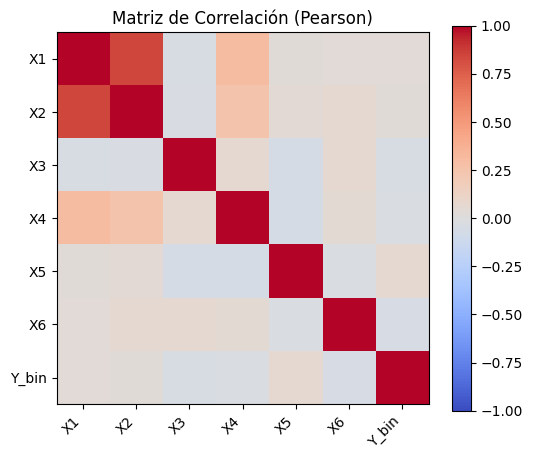

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr_pearson.values, vmin=-1, vmax=1,cmap='coolwarm')
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)
fig.colorbar(im, ax=ax)
ax.set_title('Matriz de Correlación (Pearson)')
plt.show()

## 3) Correlaciones no paramétricas: Spearman y Kendall
- **Spearman** usa rangos (monótona, no requiere linealidad).
- **Kendall** mide concordancias/discordancias; más robusta con pocos datos o empates.

In [6]:
corr_spearman = df[numeric_cols].corr(method='spearman')
corr_kendall = df[numeric_cols].corr(method='kendall')
corr_spearman, corr_kendall

(             X1        X2        X3        X4        X5        X6     Y_bin
 X1     1.000000  0.822296 -0.055492  0.306988  0.029045  0.035377  0.042764
 X2     0.822296  1.000000 -0.048964  0.227537  0.035506  0.065002  0.041016
 X3    -0.055492 -0.048964  1.000000  0.036959 -0.024791  0.071871 -0.044928
 X4     0.306988  0.227537  0.036959  1.000000 -0.065475  0.036778 -0.045313
 X5     0.029045  0.035506 -0.024791 -0.065475  1.000000 -0.002709  0.015841
 X6     0.035377  0.065002  0.071871  0.036778 -0.002709  1.000000 -0.064787
 Y_bin  0.042764  0.041016 -0.044928 -0.045313  0.015841 -0.064787  1.000000,
              X1        X2        X3        X4        X5        X6     Y_bin
 X1     1.000000  0.631968 -0.034261  0.222782  0.018886  0.024257  0.030253
 X2     0.631968  1.000000 -0.032689  0.158717  0.023760  0.044008  0.028457
 X3    -0.034261 -0.032689  1.000000  0.025010 -0.015198  0.047631 -0.030926
 X4     0.222782  0.158717  0.025010  1.000000 -0.045611  0.023535 -0.03049

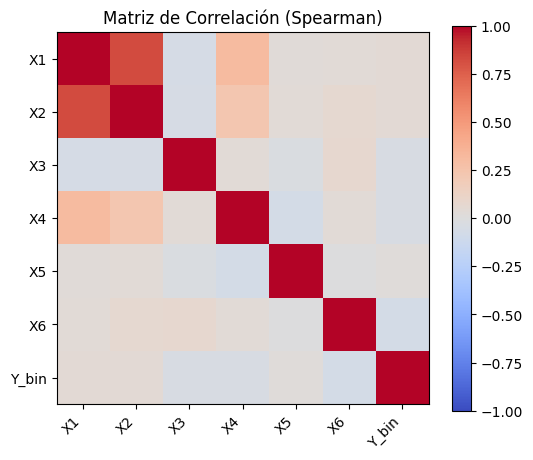

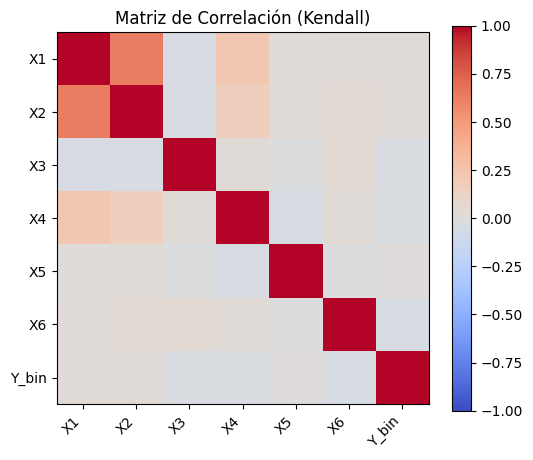

In [21]:
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr_spearman.values, vmin=-1, vmax=1,cmap='coolwarm')
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)
fig.colorbar(im, ax=ax)
ax.set_title('Matriz de Correlación (Spearman)')
plt.show()
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr_kendall.values, vmin=-1, vmax=1,cmap='coolwarm')
ax.set_xticks(range(len(numeric_cols)))
ax.set_yticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right')
ax.set_yticklabels(numeric_cols)
fig.colorbar(im, ax=ax)
ax.set_title('Matriz de Correlación (Kendall)')
plt.show()

## 4) Punto-biserial (binaria vs continua)
Es un caso especial de Pearson cuando una variable es 0/1. Usaremos `scipy.stats.pointbiserialr`.

In [7]:
r_pb, p_pb = stats.pointbiserialr(df['B'], df['Y_bin'])
print('r_punto_biserial =', r_pb, '| p-valor =', p_pb)

r_punto_biserial = 0.6978986943346637 | p-valor = 3.2691494926498986e-74


## 5) Cramer's V (categórica vs categórica)
Se deriva del **chi-cuadrado** de una tabla de contingencia. Corre entre 0 y 1.

In [8]:
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(table)[0]
    n = table.to_numpy().sum()
    r, k = table.shape
    return np.sqrt((chi2 / n) / (min(k-1, r-1)))

cv = cramers_v(df['cat1'], df['cat2'])
print('Cramer\'s V =', cv)

Cramer's V = 0.03237853833069249


## 6) Trampas y errores comunes
### a) Outliers distorsionan Pearson

In [9]:
# Correlación con outliers
r_with = stats.pearsonr(df['X1'], df['X5'])[0]

# Correlación sin outliers extremos de X5
mask = df['X5'] < 5
r_without = stats.pearsonr(df.loc[mask, 'X1'], df.loc[mask, 'X5'])[0]
print('Pearson con outliers:', r_with)
print('Pearson sin outliers:', r_without)

Pearson con outliers: 0.02880472765604433
Pearson sin outliers: -0.006580225537681933


### b) No linealidad: correlación ~0 pero relación clara

Pearson(X1, X3) = -0.04177687408432432


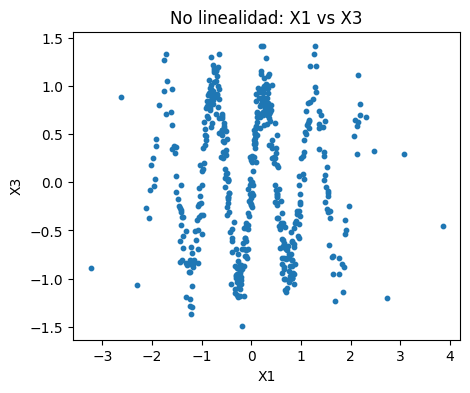

In [10]:
r_x1x3 = stats.pearsonr(df['X1'], df['X3'])[0]
print('Pearson(X1, X3) =', r_x1x3)
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(df['X1'], df['X3'], s=10)
ax.set_title('No linealidad: X1 vs X3')
ax.set_xlabel('X1')
ax.set_ylabel('X3')
plt.show()

### c) Rango restringido: baja correlación por poca variabilidad

In [11]:
r_x1x6 = stats.pearsonr(df['X1'], df['X6'])[0]
print('Pearson(X1, X6) con rango restringido en X6 =', r_x1x6)

Pearson(X1, X6) con rango restringido en X6 = 0.03177314084570541


## 7) Multicolinealidad y VIF
Cuando predictores están fuertemente correlacionados entre sí, la varianza de los coeficientes crece.
Calculamos **VIF** (Variance Inflation Factor). Regla práctica: VIF > 5–10 indica problema potencial.

In [12]:
X = df[['X1','X2','X4','X5']].copy()
X = sm.add_constant(X)
vifs = []
for i in range(1, X.shape[1]):  # saltar la constante en índice 0
    vifs.append({'variable': X.columns[i], 'VIF': variance_inflation_factor(X.values, i)})
pd.DataFrame(vifs)

,variable,VIF
0,X1,3.459563
1,X2,3.358556
2,X4,1.106739
3,X5,1.007729


### Consejos para tratar multicolinealidad
- Eliminar o combinar variables altamente correlacionadas.
- Usar regularización (Ridge/Lasso/Elastic Net).
- Aplicar PCA si el objetivo es predicción y no interpretabilidad.

## 8) Correlación parcial: \(r_{XY\cdot Z}\)
Mide la relación entre X y Y **controlando** el efecto lineal de Z. Aquí lo calculamos con residuos de OLS.

In [13]:
def partial_corr(x, y, z):
    Xz = sm.add_constant(z)
    res_x = sm.OLS(x, Xz).fit().resid
    res_y = sm.OLS(y, Xz).fit().resid
    r = stats.pearsonr(res_x, res_y)[0]
    return r

r_xy = stats.pearsonr(df['X1'], df['X2'])[0]
r_xy_z = partial_corr(df['X1'], df['X2'], df[['X4']])
print('Pearson r(X1, X2) =', r_xy)
print('Parcial r(X1, X2 | X4) =', r_xy_z)

Pearson r(X1, X2) = 0.837728095443581
Parcial r(X1, X2 | X4) = 0.8257073393855892


## 9) Autocorrelación (series de tiempo) y Durbin-Watson
La autocorrelación inflada puede crear correlaciones espurias. Probamos el estadístico **Durbin–Watson** en residuos.

In [14]:
# Serie con fuerte autocorrelación
rho = 0.8
e = np.random.normal(0, 1, n)
series = np.zeros(n)
for t in range(1, n):
    series[t] = rho*series[t-1] + e[t]

# Regresión simple para obtener residuos
t_idx = np.arange(n)
X_ts = sm.add_constant(t_idx)
ols = sm.OLS(series, X_ts).fit()
dw = sm.stats.stattools.durbin_watson(ols.resid)
print('Durbin-Watson (≈2 sin autocorrelación):', dw)


Durbin-Watson (≈2 sin autocorrelación): 0.48049668402048484


## 10) Guía rápida de interpretación
- |r| < 0.1: **traza**
- 0.1–0.3: **débil**
- 0.3–0.5: **moderada**
- 0.5–0.7: **fuerte**
- > 0.7: **muy fuerte**

⚠️ No confundir **correlación** con **causalidad**. Verifica:
- Linealidad y outliers
- Tipo de variable (usa el coeficiente correcto)
- Estabilidad temporal (no mezclar periodos distintos)
- Autocorrelación y multicolinealidad
- Posibles variables de confusión

## 11) Utilidades: función para matriz de correlación y p-valores
Calcula la matriz de correlación y la matriz de p-valores (Pearson/Spearman).

In [15]:
def corr_with_pvalues(df, method='pearson'):
    cols = df.columns
    R = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    P = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    for i, j in combinations(range(len(cols)), 2):
        x, y = df.iloc[:, i], df.iloc[:, j]
        if method == 'pearson':
            r, p = stats.pearsonr(x, y)
        elif method == 'spearman':
            r, p = stats.spearmanr(x, y)
        else:
            raise ValueError('method debe ser pearson o spearman')
        R.iat[i, j] = R.iat[j, i] = r
        P.iat[i, j] = P.iat[j, i] = p
    np.fill_diagonal(R.values, 1)
    np.fill_diagonal(P.values, 0)
    return R, P

R, P = corr_with_pvalues(df[numeric_cols], method='pearson')
R.round(3)

,X1,X2,X3,X4,X5,X6,Y_bin
X1,1.000,0.838,-0.042,0.303,0.029,0.032,0.033
X2,0.838,1.000,-0.033,0.251,0.046,0.056,0.031
X3,-0.042,-0.033,1.000,0.057,-0.062,0.066,-0.040
X4,0.303,0.251,0.057,1.000,-0.061,0.047,-0.028
X5,0.029,0.046,-0.062,-0.061,1.000,-0.025,0.065
X6,0.032,0.056,0.066,0.047,-0.025,1.000,-0.053
Y_bin,0.033,0.031,-0.040,-0.028,0.065,-0.053,1.000


## 12) Exporta resultados clave
Guardar matrices de correlación y p-valores a CSV.

In [16]:
corr_pearson.to_csv('corr_pearson.csv', index=True)
corr_spearman.to_csv('corr_spearman.csv', index=True)
R.to_csv('corr_with_pvalues.csv', index=True)
print('Archivos exportados: corr_pearson.csv, corr_spearman.csv, corr_with_pvalues.csv')

Archivos exportados: corr_pearson.csv, corr_spearman.csv, corr_with_pvalues.csv
